# Build training sets
**!!! First run the Jupyter backend setup** 

https://github.com/xiaohang007/SLICES?tab=readme-ov-file#jupyter-backend-setup

In [3]:
%matplotlib inline
from slices.utils import temporaryWorkingDirectory,splitRun,show_progress,collect_json,collect_csv
import os
import pandas as pd
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
def stratified_split(data, target_column, test_size=0.1, random_state=42):
    non_numeric = data[pd.to_numeric(data[target_column], errors='coerce').isna()]
    if not non_numeric.empty:
        print("以下行无法转换为数值类型:")
        print(non_numeric)
        print("\n无法转换的唯一值:")
        print(non_numeric[target_column].unique())
    data[target_column] = pd.to_numeric(data[target_column], errors='coerce')
    data_cleaned = data.dropna(subset=[target_column])
    print(f"\n原始数据行数: {len(data)}")
    print(f"清理后数据行数: {len(data_cleaned)}")
    data_cleaned['bin'] = pd.cut(data_cleaned[target_column], 
                         bins=[-np.inf, 0, 0.5, 1, 2, np.inf], 
                         labels=['zero', 'low', 'medium', 'high', 'very_high'])
    train_data = pd.DataFrame(columns=data_cleaned.columns)
    test_data = pd.DataFrame(columns=data_cleaned.columns)
    for bin_label in data_cleaned['bin'].unique():
        bin_data = data_cleaned[data_cleaned['bin'] == bin_label]
        if len(bin_data) > 1:
            bin_train, bin_test = train_test_split(bin_data, test_size=test_size, random_state=random_state)
        else:
            bin_train, bin_test = bin_data, pd.DataFrame()
        train_data = pd.concat([train_data, bin_train])
        test_data = pd.concat([test_data, bin_test])
    train_data = train_data.drop('bin', axis=1)
    test_data = test_data.drop('bin', axis=1)
    train_data = train_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_data = test_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return train_data, test_data

if __name__ == "__main__":
    with temporaryWorkingDirectory("./data/mp20_nonmetal/"):
        output=[]
        data_path_predix="../mp20/"
        data=pd.read_csv(data_path_predix+"test.csv")
        cifs=list(data["cif"])
        ids=list(data["material_id"])
        eform=list(data["formation_energy_per_atom"])
        bandgap=list(data["band_gap"])
        for i in range(len(ids)):
            output.append({"material_id":ids[i],"formation_energy_per_atom":eform[i],"cif":cifs[i],"band_gap":bandgap[i]})
        data=pd.read_csv(data_path_predix+"val.csv")
        cifs=list(data["cif"])
        ids=list(data["material_id"])
        eform=list(data["formation_energy_per_atom"])
        bandgap=list(data["band_gap"])
        for i in range(len(ids)):
            output.append({"material_id":ids[i],"formation_energy_per_atom":eform[i],"cif":cifs[i],"band_gap":bandgap[i]})
        data=pd.read_csv(data_path_predix+"train.csv")
        cifs=list(data["cif"])
        ids=list(data["material_id"])
        eform=list(data["formation_energy_per_atom"])
        bandgap=list(data["band_gap"])
        for i in range(len(ids)):
            output.append({"material_id":ids[i],"formation_energy_per_atom":eform[i],"cif":cifs[i],"band_gap":bandgap[i]})
        with open('cifs.json', 'w') as f:
            json.dump(output, f)
        splitRun(filename='./cifs.json',threads=16,skip_header=False)
        show_progress()
        collect_json(output="cifs_filtered.json", \
            glob_target="./**/output.json",cleanup=False)
        collect_csv(output="mp20_eform_bandgap_nonmetal.csv", \
            glob_target="./**/result.csv",cleanup=True,header="SLICES,eform,bandgap\n")
        os.system("rm cifs.json")
        data = pd.read_csv('mp20_eform_bandgap_nonmetal.csv')
        target_column = data.columns[-1]  # 假设最后一列是目标值
        train_data, test_data = stratified_split(data, target_column)
        print(train_data[target_column].value_counts(bins=5, normalize=True))
        print(test_data[target_column].value_counts(bins=5, normalize=True))
        train_data.to_csv('train_data_reduce_zero.csv', index=False)
        test_data.to_csv('test_data_reduce_zero.csv', index=False)

Computational tasks have been submitted.


     100%|███████████████| 100/100 [18:57<00:00, 11.38s/it]    


Results have been collected into: cifs_filtered.json
Results have been collected into: mp20_eform_bandgap_nonmetal.csv


# Train CrystalGPT for Single-Property Material Inverse Design (using formation energy as an example)
<span style="color:red">**CUDA in xiaohang07/slices Docker works on WSL@Windows 11 but may fail on Ubuntu; for Ubuntu, use host machine to train and generate SLICES with CrystalGPT.**</span>

**Set --epochs 5 to speed up the test run.**

**Specify the training set file path in ./crystalGPT/eform/1_train_generate/train.py**

**To accelerate the training process, consider adjusting the batch_size appropriately.**

In [11]:
from slices.utils import temporaryWorkingDirectory
import os
with temporaryWorkingDirectory("./MatterGPT/eform/1_train_generate"):
    os.system("/bin/bash -c 'source /opt/conda/etc/profile.d/conda.sh && conda activate chgnet && \
    python train.py --run_name bandgap_Aug1 --batch_size 20 --num_props 1 --max_epochs 5 --n_embd 768  --n_layer 12 --n_head 12 --learning_rate 1e-4'")

Li Li Li Li Sb Te Te Te O O O O O O O O O O O O 0 9 oo- 0 18 o-o 0 14 ooo 0 13 o-- 1 17 ooo 1 10 oo- 1 13 oo- 1 14 ooo 2 16 ooo 2 11 o-o 2 8 ooo 2 19 o-o 3 15 ooo 3 12 ooo 3 19 ooo 3 8 ooo 4 19 o-o 4 8 oo- 4 15 ooo 4 12 o-- 4 10 +o- 4 17 +-o 5 18 ooo 5 9 oo- 5 16 ooo 5 11 oo- 5 8 oo- 5 19 ooo 6 14 ooo 6 13 o-o 6 17 o-o 6 10 ooo 6 15 -oo 6 12 --o 7 11 ooo 7 16 ooo 7 9 ooo 7 18 ooo 7 13 ooo 7 14 ooo 
-1.8182863521666668
Constructing vocabulary...
Max length of slices:  308
Number of characters: 126
vocab_size: 128

['+++', '++-', '++o', '+-+', '+--', '+-o', '+o+', '+o-', '+oo', '-++', '-+-', '-+o', '--+', '---', '--o', '-o+', '-o-', '-oo', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>', 'Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'He', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 

epoch 1 iter 643: train loss 0.50840. lr 9.190441e-05: 100%|██████████| 644/644 [03:47<00:00,  2.83it/s]


test loss: 0.49157606355018085 

Saving at epoch 1 with best test loss: 0.49157606355018085


epoch 2 iter 555: train loss 0.45420. lr 7.129019e-05:  86%|████████▋ | 556/644 [03:18<00:31,  2.80it/s]
Traceback (most recent call last):
  File "/crystal/crystalGPT/eform/1_train_generate/train.py", line 101, in <module>
    df = trainer.train()
  File "/crystal/crystalGPT/eform/1_train_generate/trainer.py", line 174, in train
    train_loss = run_epoch('train')
  File "/crystal/crystalGPT/eform/1_train_generate/trainer.py", line 120, in run_epoch
    losses.append(loss.item())
KeyboardInterrupt


# Generate SLICES strings with specified $E_{form}$ = [-1,-2,-3,-4]  eV/atom
<span style="color:red">**CUDA in xiaohang07/slices Docker works on WSL@Windows 11 but may fail on Ubuntu; for Ubuntu, use host machine to train and generate SLICES with CrystalGPT.**</span>

**Set --gen_size 5 to speed up the test run.**

**To accelerate the generation process, consider adjusting the batch_size appropriately.**

In [15]:
from slices.utils import temporaryWorkingDirectory
import os
with temporaryWorkingDirectory("./MatterGPT/eform/1_train_generate"):
    os.system('''
    /bin/bash -c "source /opt/conda/etc/profile.d/conda.sh && conda activate chgnet && \
    python generate.py --model_weight bandgap_Aug1.pt --prop_targets '[-1.0, -2.0,-3,-4]' --gen_size 20 --batch_size 5 --csv_name inverse_designed_SLICES --n_head 12"
    ''')

Target 1 is : eform-1.0 eV/atom.
Target 2 is : eform-2.0 eV/atom.
Target 3 is : eform-3.0 eV/atom.
Target 4 is : eform-4.0 eV/atom.
./Voc_prior
Loading model
Model loaded


100%|██████████| 4/4 [00:36<00:00,  9.24s/it]


Total generated SLICES: 69
Unique canonical SLICES: 69
Valid ratio: 0.862
Unique ratio: 1.0


# Reconstruct crystals from SLICES, assess novelty, predict formation energy (CHGNet), and visualize

Computational tasks have been submitted.


     100%|███████████████| 100/100 [02:02<00:00,  1.22s/it]  


Results have been collected into: results.csv


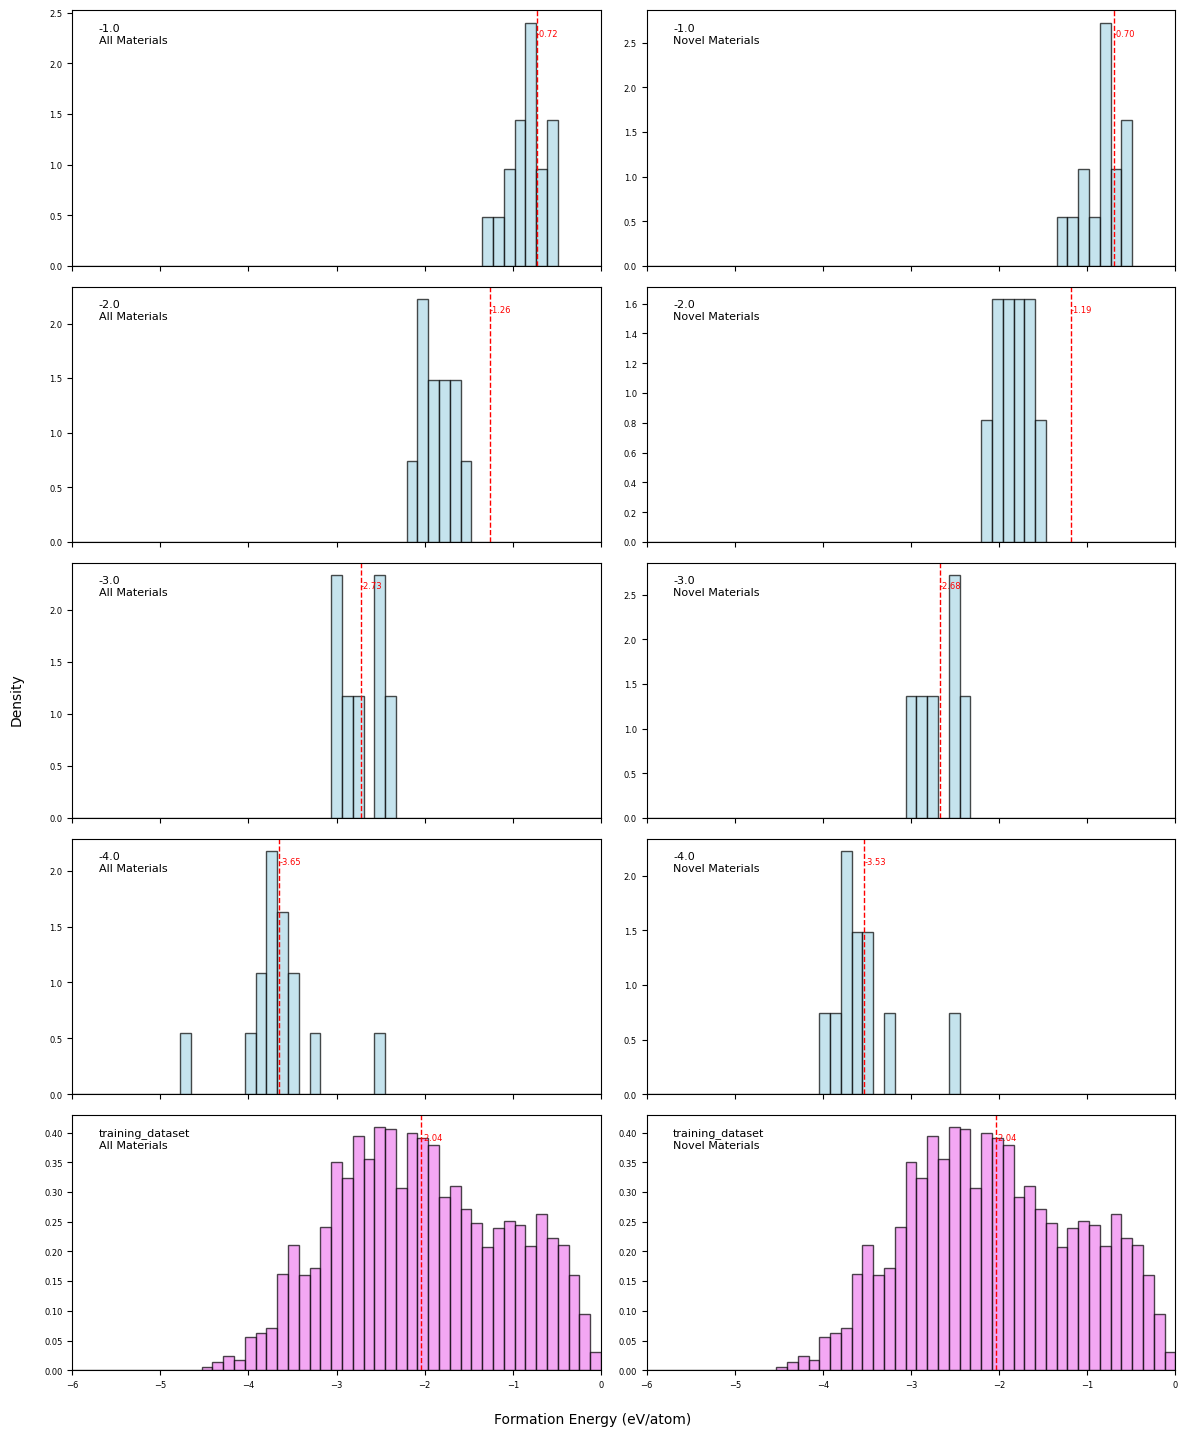

In [20]:
from slices.utils import temporaryWorkingDirectory,splitRun_csv,show_progress,collect_csv
import os
import glob
from slices.utils import splitRun_csv, show_progress, collect_csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import matplotlib.ticker as ticker
import pickle,json
from pymatgen.core.structure import Structure
def load_and_save_structure_database():
    # json file (including "cif") of training dataset for novelty check
    with open('../../../data/mp20_nonmetal/cifs_filtered.json', 'r') as f:
        cifs = json.load(f)
    structure_database = []
    for i in range(len(cifs)):
        cif_string = cifs[i]["cif"]
        try:
            stru = Structure.from_str(cif_string, "cif")
            structure_database.append([stru, cifs[i]["band_gap"]])
        except Exception as e:
            print(e)
    with open('structure_database.pkl', 'wb') as f:
        pickle.dump(structure_database, f)
def process_data():
    load_and_save_structure_database()
    splitRun_csv(filename='../1_train_generate/inverse_designed_SLICES.csv', threads=16, skip_header=True)
    show_progress()
    collect_csv(output="results.csv",
                glob_target="./job_*/result.csv", cleanup=True,
                header="eform_target,SLICES,eform_chgnet,poscar,novelty\n")
def prepare_data(results_file, training_file):
    results_1 = pd.read_csv(results_file)
    trainingset = pd.read_csv(training_file, header=0)
    
    header_values = results_1.iloc[:, 0].tolist()
    data_values = results_1.iloc[:, 2].tolist()
    trainingset_values = trainingset.iloc[:, 1].tolist()
    novelty_values = results_1.iloc[:, 4].tolist()
    data_dict = {}
    for header, value, novelty in zip(header_values, data_values, novelty_values):
        if header not in data_dict:
            data_dict[header] = {'all': [], 'novel': []}
        data_dict[header]['all'].append(value)
        if novelty == 1:
            data_dict[header]['novel'].append(value)
    sorted_keys = sorted(data_dict.keys(), reverse=True)
    return data_dict, sorted_keys, trainingset_values
def create_dataframe(data_dict, sorted_keys, trainingset_values, type='all'):
    df = pd.DataFrame({k: pd.Series(data_dict[k][type], index=range(len(data_dict[k][type]))) for k in sorted_keys})
    df = pd.concat([df, pd.Series(trainingset_values, name='training_dataset')], axis=1)
    return df
def plot_combined_histograms(all_data, novel_data, output_file):
    num_cols = len(all_data.columns)
    fig, axs = plt.subplots(num_cols, 2, figsize=(12, 3*num_cols), sharex=True)
    bins = np.linspace(-6, 0, 50)
    # Ensure axs is always 2D
    if num_cols == 1:
        axs = axs.reshape(1, -1)
    for i, col_name in enumerate(all_data.columns):
        for j, (data, title) in enumerate(zip([all_data, novel_data], ['All Materials', 'Novel Materials'])):
            color = 'violet' if col_name == 'training_dataset' else 'lightblue'
            axs[i, j].hist(data[col_name].dropna(), bins=bins, density=True, color=color, edgecolor='black', alpha=0.7)
            mu, std = norm.fit(data[col_name].dropna())
            axs[i, j].text(0.05, 0.95, f"{col_name}\n{title}", transform=axs[i, j].transAxes, fontsize=8, va='top')
            mean_val = data[col_name].mean()
            axs[i, j].axvline(mean_val, color='red', linestyle='--', linewidth=1)
            axs[i, j].text(mean_val, axs[i, j].get_ylim()[1]*0.9, f"{mean_val:.2f}", color='red', fontsize=6, ha='left')
    for ax in axs.flat:
        ax.set_xlim(-6, 0)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.text(0.5, 0.02, 'Formation Energy (eV/atom)', ha='center', va='center', fontsize=10)
    fig.text(0.02, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=10)
    plt.subplots_adjust(hspace=0, wspace=0.1)
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    return fig
if __name__ == "__main__":
    with temporaryWorkingDirectory("./MatterGPT/eform/2_inverse_eform_novelty"):
        process_data()
        data_dict, sorted_keys, trainingset_values = prepare_data("results.csv", "../../../data/mp20_nonmetal/train_data_reduce_zero.csv")
        # Process all materials
        all_materials_df = create_dataframe(data_dict, sorted_keys, trainingset_values, 'all')
        # Process novel materials
        novel_materials_df = create_dataframe(data_dict, sorted_keys, trainingset_values, 'novel')
        # Create and save the combined plot
        fig = plot_combined_histograms(all_materials_df, novel_materials_df, "combined_results.png")
        # Display the plot in Jupyter
        display(fig)
        plt.close(fig)

# Evaluate the formation energy distribution of the reconstructed crystals at PBE level (need workstation or even HPC to run VASP fastly)

In [ ]:
```bash
cd ./MatterGPT/eform/3_eform_DFT
python 1_run.py
# done
```